<a href="https://colab.research.google.com/github/Lee-nahyung/AI-image/blob/main/first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim
import torch
import torchvision.datasets as datasets
import torch.optim.lr_scheduler as lr_scheduler


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기

Saving LeopardCatAndCat.zip to LeopardCatAndCat.zip


In [2]:
!unzip LeopardCatAndCat.zip -d LeopardCatAndCat/    #menandgirl 폴더 만들어 압축 풀기

Archive:  LeopardCatAndCat.zip
   creating: LeopardCatAndCat/LeopardCatAndCat/test/
   creating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8100.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8101.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8102.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8103.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8104.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8105.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8106.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8107.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8108.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8109.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8110.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8111.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #gpu 우선으로 돌릴 것

In [4]:
#train 셋이다. 
data_path = '/content/LeopardCatAndCat/LeopardCatAndCat/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

#--train 셋이다

220


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
#test셋이다

test_path = '/content/LeopardCatAndCat/LeopardCatAndCat/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))
#--test셋이다

40


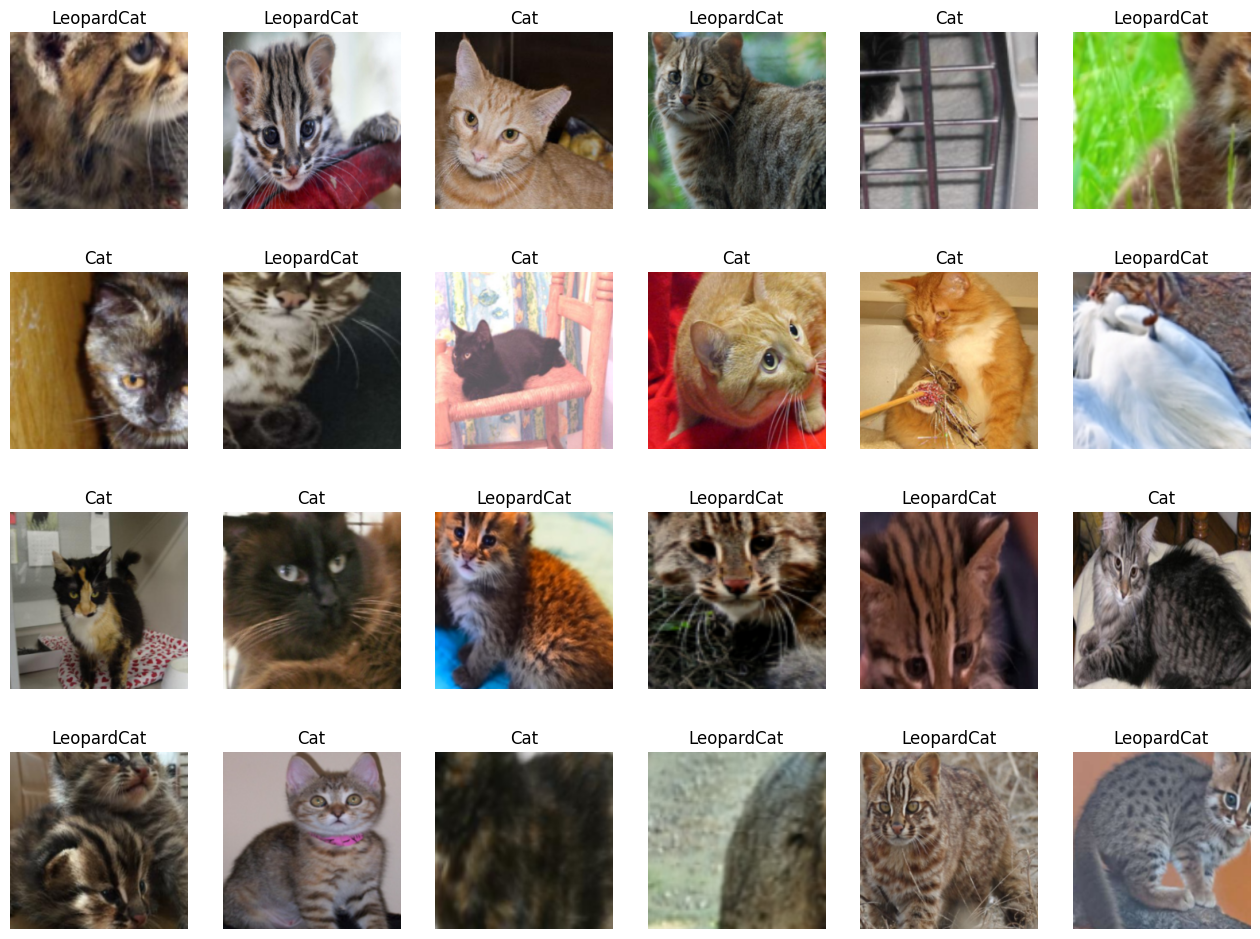

In [6]:
#dataset 보여주기
samples, labels = next(iter(train_loader))
classes = {0:'Cat', 1:'LeopardCat'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
#--dataset보여주기

In [1]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('LeopardCatAndCat/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history
  

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1).reshape(out.size(0), -1)
        out = self.linear(out)
        return out

    @staticmethod
    def ResNet18():
        return ResNet(BasicBlock, [2, 2, 2, 2])

    @staticmethod
    def ResNet34():
        return ResNet(BasicBlock, [3, 4, 6, 3])

    @staticmethod
    def ResNet50():
        return ResNet(Bottleneck, [3, 4, 6, 3])

    @staticmethod
    def ResNet101():
        return ResNet(Bottleneck, [3, 4, 23, 3])

    @staticmethod
    def ResNet152():
        return ResNet(Bottleneck, [3, 8, 36, 3])

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

net = ResNet(BasicBlock, [2,2,2,2])
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_dataset = ImageFolder('/content/LeopardCatAndCat/LeopardCatAndCat/train/', transform=transform)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)


for epoch in range(10):  # 10 epoch 수행
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력 데이터와 레이블 가져오기
        inputs, labels = data[0].to(device), data[1].to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 200 == 199:  # 매 200 배치마다 손실 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

#전이학습 test
TL_val_acc_hist = eval_model(net, test_loader, device)

NameError: ignored